# Imports

In [1]:
import random
import copy
import math
import matplotlib.pyplot as plt


# Graph dicts

In [ ]:
# A dictionary mapping graph filenames to their known chromatic numbers
GRAPH_DICT = {
    'myciel3.col': 4,
    'queen8_8.col': 9,
    'le450_15b.col': 15
}
#PRINT_EACH = 50  # Number of generations between print statements
CHROMATIC_MARGIN = 3 # Margin above known chromatic number to start with

# Declaring Functions

## Parse graph from .col file (Dataset)

In [3]:
def parse_col_file(filepath):
    adj = {}
    num_vertices = 0

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('p'):
                _, _, n, _ = line.split()
                num_vertices = int(n)
                adj = {i: set() for i in range(1, num_vertices + 1)}

            elif line.startswith('e'):
                _, u, v = line.split()
                u, v = int(u), int(v)
                adj[u].add(v)
                adj[v].add(u)
    return adj, num_vertices


## Fitness and Conflict Evaluation

In [4]:
def count_conflicts(adj, coloring):
    conflicts = 0
    for u in adj:
        for v in adj[u]:
            if u < v and coloring[u] == coloring[v]:
                conflicts += 1
    return conflicts

In [5]:
def num_colors_used(coloring):
    return len(set(coloring.values()))

In [6]:
def fitness(adj, coloring):
    conflicts = count_conflicts(adj, coloring)  
    colors = num_colors_used(coloring)

    # Upper bounds
    max_edges = sum(len(v) for v in adj.values()) // 2  # divided by 2 to avoid double counting 
    max_colors = len(adj)

    # Lexicographic encoding (conflicts dominate colors)
    return (max_edges - conflicts) * (max_colors + 1) + (max_colors - colors)


## Population Init

In [7]:
def random_coloring(num_vertices, max_colors):
    return {i: random.randint(1, max_colors) for i in range(1, num_vertices + 1)}

In [8]:
def initialize_population(pop_size, num_vertices, max_colors):
    return [random_coloring(num_vertices, max_colors) for _ in range(pop_size)]

# Selection

## Tournament Selection

In [12]:
def tournament_selection(population, adj, k=3):
    candidates = random.sample(population, k)
    return max(candidates, key=lambda c: fitness(adj, c))

## Roulette wheel

In [13]:
def roulette_wheel_selection(population, adj):
    fitness_values = [fitness(adj, c) for c in population]
    total = sum(fitness_values)

    pick = random.uniform(0, total)
    current = 0.0

    for individual, f in zip(population, fitness_values):
        current += f
        if current >= pick:
            return individual

    return population[-1]


## Stochastic Universal Sampling

In [14]:
def stochastic_universal_sampling(population, adj, num_parents=2):
    fitness_values = [fitness(adj, ind) for ind in population]

    total_fitness = sum(fitness_values)
    if total_fitness == 0:
        # Degenerate case: fallback to uniform random selection
        return random.sample(population, num_parents)

    # Distance between pointers (dr)
    step = total_fitness / num_parents

    # Random r in [0, dr)
    start = random.uniform(0, step)

    # Select patterns at r, r + dr, r + 2dr, ...
    pointers = [start + i * step for i in range(num_parents)]

    selected = []
    cumulative_fitness = 0.0
    idx = 0
    # fitness interval layout
    for ind, fit in zip(population, fitness_values):
        cumulative_fitness += fit
        while idx < num_parents and cumulative_fitness >= pointers[idx]:
            selected.append(ind)
            idx += 1

    return selected


# Crossover

## Uniform Crossover

In [17]:
def uniform_crossover(parent1, parent2):
    child = {}
    for v in parent1:
        child[v] = parent1[v] if random.random() < 0.5 else parent2[v]
    return child


## Two-Point Crossover

In [18]:
def two_point_crossover(parent1, parent2):
    vertices = list(parent1.keys())
    c1, c2 = sorted(random.sample(range(len(vertices)), 2))

    child = {}
    for i, v in enumerate(vertices):
        if c1 <= i < c2:
            child[v] = parent2[v]
        else:
            child[v] = parent1[v]

    return child


# Mutation

## Probabilistic, Conflict-Driven mutation

In [19]:
def conflict_based_mutation(coloring, adj, max_colors, mutation_rate=0.05):
    for u in adj:
        conflicts = [v for v in adj[u] if coloring[u] == coloring[v]]   # No reuse of count_conflicts because we need to get the vertices in conflict
        if conflicts and random.random() < mutation_rate:
            coloring[u] = random.randint(1, max_colors)
    return coloring


## Single gene mutation

In [20]:
def single_gene_mutation(coloring, max_colors, mutation_rate=0.05):
    v = random.choice(list(coloring.keys()))
    if random.random() < mutation_rate:
        coloring[v] = random.randint(1, max_colors)
    return coloring


# Genetic Algorithm

## Definition of the Genetic Functions:


### Tournament Selection, Conflict-Driven Mutation, Uniform crossover

In [16]:
def genetic_algorithm1(
    adj,
    num_vertices,
    max_colors,
    pop_size=100,
    generations=1000,
    elitism_rate=0.05,
    mutation_rate=0.02
):
    chromatic_number = max_colors - CHROMATIC_MARGIN   # Chromatic number 
    if chromatic_number < 5:
        print_each = 1
    if chromatic_number >= 5 and chromatic_number < 10:
        print_each = 10
    if chromatic_number >= 10 and chromatic_number < 20:
        print_each = 50
    population = initialize_population(pop_size, num_vertices, max_colors) # Initial population
    gen = 0 # Initialize generation counter here, respecting initial gen value
    last_feasible = None
    # try decreasing max_colors until chromatic number is reached
    while max_colors >= chromatic_number and gen < generations:
        print(f"Trying with max colors: {max_colors}")
        # reinitialize best solution tracking
        elite_size = int(pop_size * elitism_rate)
        found_feasible = False
        best_solution = None
        best_fitness = float("-inf")
        conflicts = []

        # main GA loop
        while gen<generations and not found_feasible:
            gen += 1
            population.sort(key=lambda c: -fitness(adj, c))  # Sort by fitness, decreasing
            elites = population[:elite_size]               # Select elites

            current_best = population[0]
            current_fitness = fitness(adj, current_best)
            current_conflicts = count_conflicts(adj, current_best)
            current_colors = num_colors_used(current_best)

            # Update global best
            if current_fitness > best_fitness and current_colors >= chromatic_number:     # New best found, don't explore solutions with colors below chromatic number
                best_solution = copy.deepcopy(current_best)     # Update best solution
                best_fitness = current_fitness                  # Update best fitness

            if gen % print_each == 0:   # Print every set number of generations
                conflicts.append(current_conflicts)
                print(
                    f"Gen {gen} | Best fitness: {best_fitness} | "
                    f"Conflicts: {count_conflicts(adj, best_solution)} | "
                    f"Colors: {num_colors_used(best_solution)}"
                )

            # First feasible solution (any number of colors)
            if current_conflicts == 0 and not found_feasible:
                print(f"Feasible solution found at generation {gen}")
                print(f"Colors: {current_colors}")
                last_feasible = copy.deepcopy(current_best)     # Update latest feasible solution
                found_feasible = True

            # Early stopping condition
            if current_conflicts == 0 and current_colors <= chromatic_number:   # Optimal solution found, colors equal chromatic number and no conflicts
                print(
                    f"Optimal solution found at generation {gen} | "
                    f"Colors: {current_colors}"
                )
                return current_best, last_feasible
            
            if found_feasible:
                max_colors -= 1
                # Repair population to respect new color bound
                for chrom in population:
                    for v in chrom:
                        if chrom[v] > max_colors:
                            chrom[v] = random.randint(1, max_colors)
            else:
                new_population = elites.copy()  # Start new population with elites (unchanged)

                while len(new_population) < pop_size:   # Fill the rest of the population using tournament selection, crossover, and mutation
                    p1 = tournament_selection(population, adj)
                    p2 = tournament_selection(population, adj)

                    child = uniform_crossover(p1, p2)
                    conflict_based_mutation(child, adj, max_colors, mutation_rate)

                    new_population.append(child)

                population = new_population

    return best_solution, last_feasible


### Stochastic universal sampling, uniform crossover, conflict driven mutation

In [21]:
def genetic_algorithm2(
    adj,
    num_vertices,
    max_colors,
    pop_size=100,
    generations=1000,
    elitism_rate=0.05,
    mutation_rate=0.02,
    verbose=True
):
    iteration_fitness = []
    chromatic_number = max_colors - CHROMATIC_MARGIN   # Chromatic number 
    if chromatic_number < 5:
        print_each = 1
    if chromatic_number >= 5 and chromatic_number < 10:
        print_each = 10
    if chromatic_number >= 10 and chromatic_number < 20:
        print_each = 50
    population = initialize_population(pop_size, num_vertices, max_colors) # Initial population
    gen = 0 # Initialize generation counter here, respecting initial gen value
    last_feasible = None
    # try decreasing max_colors until chromatic number is reached
    while max_colors >= chromatic_number and gen < generations:
        if verbose: print(f"Trying with max colors: {max_colors}")
        # reinitialize best solution tracking
        elite_size = int(pop_size * elitism_rate)
        found_feasible = False
        best_solution = None
        best_fitness = float("-inf")
        conflicts = []

        # main GA loop
        while gen<generations and not found_feasible:
            gen += 1
            population.sort(key=lambda c: -fitness(adj, c))  # Sort by fitness, decreasing
            elites = population[:elite_size]               # Select elites

            current_best = population[0]
            current_fitness = fitness(adj, current_best)
            current_conflicts = count_conflicts(adj, current_best)
            current_colors = num_colors_used(current_best)

            # Update global best
            if current_fitness > best_fitness and current_colors >= chromatic_number:     # New best found, don't explore solutions with colors below chromatic number
                best_solution = copy.deepcopy(current_best)     # Update best solution
                best_fitness = current_fitness                  # Update best fitness

            if gen % print_each == 0:   # Print every set number of generations
                conflicts.append(current_conflicts)
                iteration_fitness.append({gen:best_fitness})
                if verbose: print(
                    f"Gen {gen} | Best fitness: {best_fitness} | "
                    f"Conflicts: {count_conflicts(adj, best_solution)} | "
                    f"Colors: {num_colors_used(best_solution)}"
                )

            # First feasible solution (any number of colors)
            if current_conflicts == 0 and not found_feasible:
                if verbose: print(f"Feasible solution found at generation {gen}")
                if verbose: print(f"Colors: {current_colors}")
                last_feasible = copy.deepcopy(current_best)     # Update latest feasible solution
                found_feasible = True

            # Early stopping condition
            if current_conflicts == 0 and current_colors <= chromatic_number:   # Optimal solution found, colors equal chromatic number and no conflicts
                if verbose: print(
                    f"Optimal solution found at generation {gen} | "
                    f"Colors: {current_colors}"
                )
                return current_best, last_feasible, iteration_fitness
            
            if found_feasible:
                max_colors -= 1
                # Repair population to respect new color bound
                for chrom in population:
                    for v in chrom:
                        if chrom[v] > max_colors:
                            chrom[v] = random.randint(1, max_colors)
            else:
                new_population = elites.copy()  # Start new population with elites (unchanged)

                mating_pool = stochastic_universal_sampling(population, adj, pop_size - elite_size)
                while len(new_population) < pop_size:   # Fill the rest of the population using selection, crossover, and mutation
                    p1, p2 = random.sample(mating_pool, 2)
                    child = uniform_crossover(p1, p2)
                    conflict_based_mutation(child, adj, max_colors, mutation_rate)

                    new_population.append(child)

                population = new_population

    return best_solution, last_feasible, iteration_fitness


### Tournament Selection, Two point crossover, Single gene mutation

In [ ]:
def genetic_algorithm3(
    adj,
    num_vertices,
    max_colors,
    pop_size=100,
    generations=1000,
    elitism_rate=0.05,
    mutation_rate=0.02
):
    chromatic_number = max_colors - CHROMATIC_MARGIN   # Chromatic number 
    if chromatic_number < 5:
        print_each = 1
    if chromatic_number >= 5 and chromatic_number < 10:
        print_each = 10
    if chromatic_number >= 10 and chromatic_number < 20:
        print_each = 50
    population = initialize_population(pop_size, num_vertices, max_colors) # Initial population
    gen = 0 # Initialize generation counter here, respecting initial gen value
    last_feasible = None
    # try decreasing max_colors until chromatic number is reached
    while max_colors >= chromatic_number and gen < generations:
        print(f"Trying with max colors: {max_colors}")
        # reinitialize best solution tracking
        elite_size = int(pop_size * elitism_rate)
        found_feasible = False
        best_solution = None
        best_fitness = float("-inf")
        conflicts = []

        # main GA loop
        while gen<generations and not found_feasible:
            gen += 1
            population.sort(key=lambda c: -fitness(adj, c))  # Sort by fitness, decreasing
            elites = population[:elite_size]               # Select elites

            current_best = population[0]
            current_fitness = fitness(adj, current_best)
            current_conflicts = count_conflicts(adj, current_best)
            current_colors = num_colors_used(current_best)

            # Update global best
            if current_fitness > best_fitness and current_colors >= chromatic_number:     # New best found, don't explore solutions with colors below chromatic number
                best_solution = copy.deepcopy(current_best)     # Update best solution
                best_fitness = current_fitness                  # Update best fitness

            if gen % print_each == 0:   # Print every set number of generations
                conflicts.append(current_conflicts)
                print(
                    f"Gen {gen} | Best fitness: {best_fitness} | "
                    f"Conflicts: {count_conflicts(adj, best_solution)} | "
                    f"Colors: {num_colors_used(best_solution)}"
                )

            # First feasible solution (any number of colors)
            if current_conflicts == 0 and not found_feasible:
                print(f"Feasible solution found at generation {gen}")
                print(f"Colors: {current_colors}")
                last_feasible = copy.deepcopy(current_best)     # Update latest feasible solution
                found_feasible = True

            # Early stopping condition
            if current_conflicts == 0 and current_colors <= chromatic_number:   # Optimal solution found, colors equal chromatic number and no conflicts
                print(
                    f"Optimal solution found at generation {gen} | "
                    f"Colors: {current_colors}"
                )
                return current_best, last_feasible
            
            if found_feasible:
                max_colors -= 1
                # Repair population to respect new color bound
                for chrom in population:
                    for v in chrom:
                        if chrom[v] > max_colors:
                            chrom[v] = random.randint(1, max_colors)
            else:
                new_population = elites.copy()  # Start new population with elites (unchanged)

                while len(new_population) < pop_size:   # Fill the rest of the population using tournament selection, crossover, and mutation
                    p1 = tournament_selection(population, adj)
                    p2 = tournament_selection(population, adj)

                    child = two_point_crossover(p1, p2)
                    single_gene_mutation(child, max_colors, mutation_rate)

                    new_population.append(child)

                population = new_population

    return best_solution, last_feasible


## Usage of the Genetic Algorithm

### Tournament Selection, Conflict-Driven Mutation, Uniform crossover

In [ ]:
if __name__ == "__main__":
    for filename, chromatic_number in GRAPH_DICT.items():
        adj, n = parse_col_file(filename)

        max_colors = chromatic_number + CHROMATIC_MARGIN

        print("=" * 55)
        print(f"{filename}: n={n}, chromatic_number={chromatic_number} max_colors={max_colors}")
        print("=" * 55)

        solution, feasible = genetic_algorithm1(
            adj=adj,
            num_vertices=n,
            max_colors=max_colors,
            pop_size=200,
        )

        print("=" * 50)
        print("Final solution:")
        print("Conflicts:", count_conflicts(adj, solution))
        print("Colors used:", num_colors_used(solution))    
        print("=" * 50)
        if feasible is not None:
            print("Latest feasible solution:")
            print("Conflicts:", count_conflicts(adj, feasible))
            print("Colors used:", num_colors_used(feasible))
            print("=" * 50)



myciel3.col: n=11, chromatic_number=4 max_colors=7
Trying with max colors: 7
Gen 1 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 1
Colors: 5
Trying with max colors: 6
Gen 2 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 2
Colors: 5
Trying with max colors: 5
Gen 3 | Best fitness: 235 | Conflicts: 1 | Colors: 4
Gen 4 | Best fitness: 247 | Conflicts: 0 | Colors: 4
Feasible solution found at generation 4
Colors: 4
Optimal solution found at generation 4 | Colors: 4
Final solution:
Conflicts: 0
Colors used: 4
Latest feasible solution:
Conflicts: 0
Colors used: 4
queen8_8.col: n=64, chromatic_number=9 max_colors=12
Trying with max colors: 12
Gen 10 | Best fitness: 45227 | Conflicts: 33 | Colors: 12
Gen 20 | Best fitness: 45877 | Conflicts: 23 | Colors: 12
Gen 30 | Best fitness: 46332 | Conflicts: 16 | Colors: 12
Gen 40 | Best fitness: 46917 | Conflicts: 7 | Colors: 12
Gen 50 | Best fitness: 47242 | Conflicts: 2 | Col

### Stochastic universal sampling, Conflict-Driven Mutation, Uniform crossover

In [29]:
if __name__ == "__main__":
    for filename, chromatic_number in GRAPH_DICT.items():
        adj, n = parse_col_file(filename)

        max_colors = chromatic_number + CHROMATIC_MARGIN

        print("=" * 55)
        print(f"{filename}: n={n}, chromatic_number={chromatic_number} max_colors={max_colors}")
        print("=" * 55)

        solution, feasible = genetic_algorithm2(
            adj=adj,
            num_vertices=n,
            max_colors=max_colors,
            pop_size=200,
        )

        print("=" * 50)
        print("Final solution:")
        print("Conflicts:", count_conflicts(adj, solution))
        print("Colors used:", num_colors_used(solution))    
        print("=" * 50)
        if feasible is not None:
            print("Latest feasible solution:")
            print("Conflicts:", count_conflicts(adj, feasible))
            print("Colors used:", num_colors_used(feasible))
            print("=" * 50)



myciel3.col: n=11, chromatic_number=4 max_colors=7
Trying with max colors: 7
Gen 1 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 1
Colors: 5
Trying with max colors: 6
Gen 2 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 2
Colors: 5
Trying with max colors: 5
Gen 3 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 3
Colors: 5
Trying with max colors: 4
Gen 4 | Best fitness: 247 | Conflicts: 0 | Colors: 4
Feasible solution found at generation 4
Colors: 4
Optimal solution found at generation 4 | Colors: 4
Final solution:
Conflicts: 0
Colors used: 4
Latest feasible solution:
Conflicts: 0
Colors used: 4
queen8_8.col: n=64, chromatic_number=9 max_colors=12
Trying with max colors: 12
Gen 10 | Best fitness: 45032 | Conflicts: 36 | Colors: 12
Gen 20 | Best fitness: 45032 | Conflicts: 36 | Colors: 12
Gen 30 | Best fitness: 45032 | Conflicts: 36 | Colors: 12
Gen 40 | Best fitness: 45032 |

### Tournament Selection, Two point crossover, Single gene mutation

In [19]:
if __name__ == "__main__":
    for filename, chromatic_number in GRAPH_DICT.items():
        adj, n = parse_col_file(filename)

        max_colors = chromatic_number + CHROMATIC_MARGIN

        print("=" * 55)
        print(f"{filename}: n={n}, chromatic_number={chromatic_number} max_colors={max_colors}")
        print("=" * 55)

        solution, feasible = genetic_algorithm3(
            adj=adj,
            num_vertices=n,
            max_colors=max_colors,
            pop_size=200,
        )

        print("=" * 50)
        print("Final solution:")
        print("Conflicts:", count_conflicts(adj, solution))
        print("Colors used:", num_colors_used(solution))    
        print("=" * 50)
        if feasible is not None:
            print("Latest feasible solution:")
            print("Conflicts:", count_conflicts(adj, feasible))
            print("Colors used:", num_colors_used(feasible))
            print("=" * 50)



myciel3.col: n=11, chromatic_number=4 max_colors=7
Trying with max colors: 7
Gen 1 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 1
Colors: 5
Trying with max colors: 6
Gen 2 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 2
Colors: 5
Trying with max colors: 5
Gen 3 | Best fitness: 247 | Conflicts: 0 | Colors: 4
Feasible solution found at generation 3
Colors: 4
Optimal solution found at generation 3 | Colors: 4
Final solution:
Conflicts: 0
Colors used: 4
Latest feasible solution:
Conflicts: 0
Colors used: 4
queen8_8.col: n=64, chromatic_number=9 max_colors=12
Trying with max colors: 12
Gen 10 | Best fitness: 45487 | Conflicts: 29 | Colors: 12
Gen 20 | Best fitness: 46332 | Conflicts: 16 | Colors: 12
Gen 30 | Best fitness: 46787 | Conflicts: 9 | Colors: 12
Gen 40 | Best fitness: 47047 | Conflicts: 5 | Colors: 12
Gen 50 | Best fitness: 47242 | Conflicts: 2 | Colors: 12
Gen 60 | Best fitness: 47242 | Conflicts: 2 | 

## Parameter tuning with the fastest method: 
Since the Stochastic universal sampling, Conflict-Driven Mutation, Uniform crossover method has performed almost twice as fast as the other options with the small and medium graphs, This section will cover parameter tuning on this option, to find the best method.

In [34]:
POP_SIZES   = [100, 200, 300]
ELITISMS    = [0.02, 0.05, 0.08]
MUTATIONS   = [0.02, 0.03, 0.05]

best_score = -float("inf")
best_config = None
adj, n = parse_col_file("queen8_8.col")
print(f"Tuning hyperparameters for queen8_8.col with n={n}")
for pop in POP_SIZES:
    for elite in ELITISMS:
        for mut in MUTATIONS:
            try:
                solution, _ = genetic_algorithm2(
                    adj, n, max_colors,
                    pop_size=pop,
                    elitism_rate=elite,
                    mutation_rate=mut,
                    generations=2000,
                    verbose=False
                )
                score = fitness(adj, solution)
                if score > best_score:
                    best_score = score
                    best_config = (pop, elite, mut)
                print(f"Config: Pop={pop}, Elite={elite}, Mut={mut} => Score={score}")
            except Exception as e:
                print(f"Config: Pop={pop}, Elite={elite}, Mut={mut} => Failed with error: {e}")

best_pop_size, best_elitism_rate, best_mutation_rate = best_config
print("Best configuration found:")
print(f"Population Size: {best_pop_size}")
print(f"Elitism Rate: {best_elitism_rate}")
print(f"Mutation Rate: {best_mutation_rate}")


Tuning hyperparameters for queen8_8.col with n=64
Config: Pop=100, Elite=0.02, Mut=0.02 => Score=46722
Config: Pop=100, Elite=0.02, Mut=0.03 => Score=46722
Config: Pop=100, Elite=0.02, Mut=0.05 => Score=46267
Config: Pop=100, Elite=0.05, Mut=0.02 => Score=47114
Config: Pop=100, Elite=0.05, Mut=0.03 => Score=47243
Config: Pop=100, Elite=0.05, Mut=0.05 => Score=47307
Config: Pop=100, Elite=0.08, Mut=0.02 => Score=47244
Config: Pop=100, Elite=0.08, Mut=0.03 => Score=47114
Config: Pop=100, Elite=0.08, Mut=0.05 => Score=47179
Config: Pop=200, Elite=0.02, Mut=0.02 => Score=46917
Config: Pop=200, Elite=0.02, Mut=0.03 => Score=46787
Config: Pop=200, Elite=0.02, Mut=0.05 => Score=46787
Config: Pop=200, Elite=0.05, Mut=0.02 => Score=47309
Config: Pop=200, Elite=0.05, Mut=0.03 => Score=47243
Config: Pop=200, Elite=0.05, Mut=0.05 => Score=47308
Config: Pop=200, Elite=0.08, Mut=0.02 => Score=47308
Config: Pop=200, Elite=0.08, Mut=0.03 => Score=47308
Config: Pop=200, Elite=0.08, Mut=0.05 => Score=47

### Manual run of the best hyperparams tuned

In [23]:
best_pop_size, best_elitism_rate, best_mutation_rate = 200, 0.05, 0.02

## Running GA with best params and algorithms on all the graphs

In [36]:
if __name__ == "__main__":
    for filename, chromatic_number in GRAPH_DICT.items():
        adj, n = parse_col_file(filename)

        max_colors = chromatic_number + CHROMATIC_MARGIN

        print("=" * 55)
        print(f"{filename}: n={n}, chromatic_number={chromatic_number} max_colors={max_colors}")
        print("=" * 55)

        solution, feasible = genetic_algorithm2(
            adj=adj,
            num_vertices=n,
            max_colors=max_colors,
            generations=2000,
            pop_size=best_pop_size,
            elitism_rate=best_elitism_rate,
            mutation_rate=best_mutation_rate
        )

        print("=" * 50)
        print("Final solution:")
        print("Conflicts:", count_conflicts(adj, solution))
        print("Colors used:", num_colors_used(solution))    
        print("=" * 50)
        if feasible is not None:
            print("Latest feasible solution:")
            print("Conflicts:", count_conflicts(adj, feasible))
            print("Colors used:", num_colors_used(feasible))
            print("=" * 50)



myciel3.col: n=11, chromatic_number=4 max_colors=7
Trying with max colors: 7
Gen 1 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 1
Colors: 5
Trying with max colors: 6
Gen 2 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 2
Colors: 5
Trying with max colors: 5
Gen 3 | Best fitness: 246 | Conflicts: 0 | Colors: 5
Feasible solution found at generation 3
Colors: 5
Trying with max colors: 4
Gen 4 | Best fitness: 235 | Conflicts: 1 | Colors: 4
Gen 5 | Best fitness: 247 | Conflicts: 0 | Colors: 4
Feasible solution found at generation 5
Colors: 4
Optimal solution found at generation 5 | Colors: 4
Final solution:
Conflicts: 0
Colors used: 4
Latest feasible solution:
Conflicts: 0
Colors used: 4
queen8_8.col: n=64, chromatic_number=9 max_colors=12
Trying with max colors: 12
Gen 10 | Best fitness: 44902 | Conflicts: 38 | Colors: 12
Gen 20 | Best fitness: 45162 | Conflicts: 34 | Colors: 12
Gen 30 | Best fitness: 45162 | Conf

## Plotting Fitness against Generations for small and medium graph

dict_items([('queen8_8.col', 9)])
queen8_8.col: n=64, chromatic_number=9 max_colors=12
Trying with max colors: 12
Gen 10 | Best fitness: 44837 | Conflicts: 39 | Colors: 12
Gen 20 | Best fitness: 45097 | Conflicts: 35 | Colors: 12
Gen 30 | Best fitness: 45292 | Conflicts: 32 | Colors: 12
Gen 40 | Best fitness: 45292 | Conflicts: 32 | Colors: 12
Gen 50 | Best fitness: 45357 | Conflicts: 31 | Colors: 12
Gen 60 | Best fitness: 45357 | Conflicts: 31 | Colors: 12
Gen 70 | Best fitness: 45487 | Conflicts: 29 | Colors: 12
Gen 80 | Best fitness: 45682 | Conflicts: 26 | Colors: 12
Gen 90 | Best fitness: 45747 | Conflicts: 25 | Colors: 12
Gen 100 | Best fitness: 45942 | Conflicts: 22 | Colors: 12
Gen 110 | Best fitness: 46072 | Conflicts: 20 | Colors: 12
Gen 120 | Best fitness: 46137 | Conflicts: 19 | Colors: 12
Gen 130 | Best fitness: 46202 | Conflicts: 18 | Colors: 12
Gen 140 | Best fitness: 46462 | Conflicts: 14 | Colors: 12
Gen 150 | Best fitness: 46527 | Conflicts: 13 | Colors: 12
Gen 160 | 

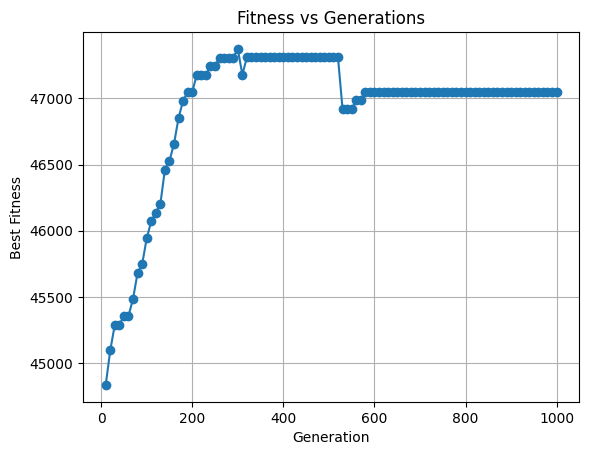

In [25]:
if __name__ == "__main__":
    for filename, chromatic_number in GRAPH_DICT.items():
        adj, n = parse_col_file(filename)
        print(GRAPH_DICT.items())
        max_colors = chromatic_number + CHROMATIC_MARGIN

        print("=" * 55)
        print(f"{filename}: n={n}, chromatic_number={chromatic_number} max_colors={max_colors}")
        print("=" * 55)

        solution, feasible, iterations_fitness = genetic_algorithm2(
            adj=adj,
            num_vertices=n,
            max_colors=max_colors,
            generations=1000,
            pop_size=best_pop_size,
            elitism_rate=best_elitism_rate,
            mutation_rate=best_mutation_rate
        )

        
    generations = []
    fitness_values = []
    for entry in iterations_fitness:
        for gen, fitness in entry.items():
            generations.append(gen)
            fitness_values.append(fitness)
            
    plt.figure()
    plt.plot(generations, fitness_values, marker='o')
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Fitness vs Generations")
    plt.grid(True)
    plt.show()

    

        

# Tabu Search

## Implementation of an optimized conflict storage
Using a data structure reduces the amount of computations since the tabu search requires not only the amount of conflicts but where have they appeared in order to generate meaningful neighborhood moves, because only recoloring conflicted vertices can reduce conflicts.
The total conflict count alone provides no structural information about where the problem is, making targeted local search impossible.

In [19]:
def conflicting_vertices(adj, coloring):
    conflicts = set()
    for u in adj:
        for v in adj[u]:
            if u < v and coloring[u] == coloring[v]:
                conflicts.add(u)
                conflicts.add(v)
    return list(conflicts)


## Implementation of the algorithm

In [20]:
def tabu_search(
    adj,
    num_vertices,
    max_colors,
    max_iterations=1000,
    tabu_tenure=7,      # Number of iterations a move remains tabu
    aspiration=True,    # Allow aspiration criterion: override tabu if illegal move improves best solution
):
    chromatic_number = max_colors - CHROMATIC_MARGIN   # Chromatic number
    if chromatic_number < 5:
        print_each = 1
    if chromatic_number >= 5 and chromatic_number < 10:
        print_each = 100
    if chromatic_number >= 10 and chromatic_number < 20:
        print_each = 500
    current = random_coloring(num_vertices, max_colors)
    current_conflicts = count_conflicts(adj, current)
    current_colors = num_colors_used(current)

    best = copy.deepcopy(current)
    best_conflicts = current_conflicts
    best_colors = current_colors
    found_optimal = False
    latest_feasible = None
    tabu_list = {}
    iteration = 0

    while iteration < max_iterations and not found_optimal:

        conflicted = conflicting_vertices(adj, current)
        best_move = None
        best_score = (float("inf"), float("inf"))

        for v in conflicted:
            original_color = current[v]

            for c in range(1, max_colors + 1):
                if c != original_color:

                    current[v] = c
                    new_conflicts = count_conflicts(adj, current)
                    new_colors = num_colors_used(current)

                    score = (new_conflicts, new_colors)
                    delta_better = score < best_score

                    move = (v, c)
                    tabu = move in tabu_list and tabu_list[move] > iteration

                    if tabu and aspiration:
                        if (new_conflicts < best_conflicts or
                        (new_conflicts == best_conflicts and new_colors < best_colors)):
                            tabu = False

                    if not tabu and delta_better:
                        best_score = score
                        best_move = (v, c, new_conflicts, new_colors)

                    current[v] = original_color

        if best_move is not None:
            v, c, new_conflicts, new_colors = best_move
            old_color = current[v]

            current[v] = c
            current_conflicts = new_conflicts
            current_colors = new_colors

            tabu_list[(v, old_color)] = iteration + tabu_tenure

            # Update global best using lexicographic objective
            if (current_conflicts < best_conflicts or
            (current_conflicts == best_conflicts and current_colors < best_colors)):
                best = copy.deepcopy(current)
                best_conflicts = current_conflicts
                best_colors = current_colors
        


        if iteration % print_each == 0:
            print(
                f"Iter {iteration} | "
                f"Conflicts: {current_conflicts} | "
                f"Colors: {current_colors} | "
                f"Best colors: {best_colors}"
            )
        
        # First feasible solution (any number of colors)
        if best_conflicts == 0 and best_colors <= max_colors:
            if max_colors != chromatic_number and best_colors != chromatic_number: #If we have not reached chromatic number yet --> try reducing colors
                max_colors -= 1
                print(f"Feasible solution found at iteration {iteration} | "
                        f"Conflicts: {current_conflicts} | "
                        f"Colors: {best_colors} | "
                        f"max_colors reduced to: {max_colors}")
                # store latest feasible solution
                latest_feasible = copy.deepcopy(best)
                # reinitialize current solution
                current = random_coloring(num_vertices, max_colors)
                current_conflicts = count_conflicts(adj, current)
                current_colors = num_colors_used(current)
                best = copy.deepcopy(current)
                best_conflicts = current_conflicts
                best_colors = current_colors
            
            
        
        # Early stopping condition
        if best_conflicts == 0 and best_colors <= chromatic_number:
            print(
                f"Optimal solution found at iteration {iteration} | "
                f"Colors: {best_colors}"
            )
            found_optimal = True

        iteration += 1

    return best, latest_feasible


## Usage of Tabu Search

In [62]:
if __name__ == "__main__":
    for filename, chromatic_number in GRAPH_DICT.items():
        adj, n = parse_col_file(filename)

        max_colors = chromatic_number + CHROMATIC_MARGIN

        print("=" * 50)
        print(f"{filename}: n={n}, chromatic_number={chromatic_number} max_colors={max_colors}")
        print("=" * 50)

        solution, feasible = tabu_search(
            adj=adj,
            num_vertices=n,
            max_colors=max_colors,
            max_iterations=5000,
            tabu_tenure=5,
        )
        print("=" * 50)
        print("Final solution:")
        print("Conflicts:", count_conflicts(adj, solution))
        print("Colors used:", num_colors_used(solution))    
        print("=" * 50)
        if feasible is not None:
            print("Latest feasible solution:")
            print("Conflicts:", count_conflicts(adj, feasible))
            print("Colors used:", num_colors_used(feasible))
            print("=" * 50)


myciel3.col: n=11, chromatic_number=4 max_colors=7
Iter 0 | Conflicts: 0 | Colors: 6 | Best colors: 6
Feasible solution found at iteration 0 | Conflicts: 0 | Colors: 6 | max_colors reduced to: 6
Iter 1 | Conflicts: 2 | Colors: 4 | Best colors: 4
Iter 2 | Conflicts: 1 | Colors: 4 | Best colors: 4
Iter 3 | Conflicts: 0 | Colors: 4 | Best colors: 4
Optimal solution found at iteration 3 | Colors: 4
Final solution:
Conflicts: 0
Colors used: 4
Latest feasible solution:
Conflicts: 0
Colors used: 6
queen8_8.col: n=64, chromatic_number=9 max_colors=12
Iter 0 | Conflicts: 74 | Colors: 12 | Best colors: 12
Feasible solution found at iteration 36 | Conflicts: 0 | Colors: 12 | max_colors reduced to: 11
Feasible solution found at iteration 89 | Conflicts: 0 | Colors: 11 | max_colors reduced to: 10
Iter 100 | Conflicts: 36 | Colors: 10 | Best colors: 10
Feasible solution found at iteration 171 | Conflicts: 0 | Colors: 10 | max_colors reduced to: 9
Iter 200 | Conflicts: 16 | Colors: 9 | Best colors: 9

# Simmulated Annealing

## Algorithm implementation

In [58]:
def simulated_annealing(
    adj,
    num_vertices,
    max_colors,
    vert_list,
    max_iterations=70000,
    initial_temp=17.0,
    cooling_rate=0.9995,
    conflict_weight=1000,
    verbose=True
):
    chromatic_number = max_colors - CHROMATIC_MARGIN   # Chromatic number
    if chromatic_number < 5:
        print_each = 5
    if chromatic_number >= 5 and chromatic_number < 10:
        print_each = 500
    if chromatic_number >= 10 and chromatic_number < 20:
        print_each = 1000

    # initialize current
    current = random_coloring(num_vertices, max_colors)
    current_conflicts = count_conflicts(adj, current)
    current_colors = num_colors_used(current)
    found_optimal = False
    latest_feasible = None
    best = copy.deepcopy(current)
    best_conflicts = current_conflicts
    best_colors = current_colors
    temperature = initial_temp
    iteration = 0
    # main SA loop
    while (iteration < max_iterations and temperature > 1e-6) and not found_optimal:

        # Pick a vertex biased toward conflicts
        conflicted = conflicting_vertices(adj, current)
        # if there are conflicted vertices, pick one of them
        if len(conflicted) > 0:
            v = random.choice(conflicted)
        else:
            # otherwise pick any vertex
            v = random.choice(vert_list)

        # propose a new color
        original_color = current[v]
        new_color = random.randint(1, max_colors)

        if new_color != original_color:

            current[v] = new_color
            # evaluate new solution
            new_conflicts = count_conflicts(adj, current)
            new_colors = num_colors_used(current)
            # Calculate change in objective function. conflicts weighted more heavily --> prioritize feasible solutions then decrease colors
            delta = (
                (new_conflicts - current_conflicts) * conflict_weight
                + (new_colors - current_colors)
            )

            accept = False
            # if new solution is better, accept it
            if delta <= 0:
                accept = True
            else:
            # else accept with a probability --> Allows uphill moves early to escape local minima.
                prob = math.exp(-delta / temperature)   # Acceptance probability = e^(-delta / T)
                accept = random.random() < prob

            if accept:
                current_conflicts = new_conflicts
                current_colors = new_colors

                if (
                    current_conflicts < best_conflicts or
                    (current_conflicts == best_conflicts and current_colors < best_colors)
                ):
                    best = copy.deepcopy(current)
                    best_conflicts = current_conflicts
                    best_colors = current_colors
            else:
                #revert the color change
                current[v] = original_color

        # Cool down and increment iteration
        temperature *= cooling_rate
        iteration += 1

        if iteration % print_each == 0:
            if verbose: 
                print(
                f"Iter {iteration} | "
                f"T={temperature:.4f} | "
                f"Conflicts: {current_conflicts} | "
                f"Colors: {current_colors} | "
                f"Best colors: {best_colors}"
                )
        
        # First feasible solution (any number of colors)
        if current_conflicts == 0 and best_colors <= max_colors:
            if max_colors != chromatic_number and best_colors != chromatic_number: #If we have not reached chromatic number yet --> try reducing colors
                max_colors -= 1
                if verbose: print(f"Feasible solution found at iteration {iteration}")
                if verbose: print(f"Colors: {best_colors}")
                # store latest feasible solution
                latest_feasible = copy.deepcopy(best)
                # reinitialize current solution
                current = random_coloring(num_vertices, max_colors)
                current_conflicts = count_conflicts(adj, current)
                current_colors = num_colors_used(current)
                best = copy.deepcopy(current)
                best_conflicts = current_conflicts
                best_colors = current_colors

        # Early stopping condition
        if best_conflicts == 0 and best_colors == chromatic_number:
            if verbose: 
                print(
                f"Optimal solution found at iteration {iteration} | "
                f"T={temperature:.4f} | "
                f"Conflicts: {current_conflicts} | "
                f"Colors: {current_colors} | "
                f"Best colors: {best_colors}"
                )
            found_optimal = True

    return best, latest_feasible


## Parameter tuning on Simulated Annealing

In [95]:
ITERATIONS = [30000, 40000, 50000, 60000, 70000]
INITIAL_TEMPS = [12.0, 14.0, 15.5, 17.0]
COOLING_RATES = [0.999, 0.9993, 0.9995, 0.9997, 0.9999]
CONFLICT_WEIGHTS = [200, 500, 1000, 2000]

best_score = -float("inf")
best_config = None

adj, n = parse_col_file("queen8_8.col")
vert_list = list(adj.keys())

print(f"Tuning SA hyperparameters for queen8_8.col (n={n})")
for i in range(3):  # multiple runs to average out randomness
    for iters in ITERATIONS:
        for temp in INITIAL_TEMPS:
            for cool in COOLING_RATES:
                for cw in CONFLICT_WEIGHTS:
                    try:
                        solution, _ = simulated_annealing(
                            adj=adj,
                            num_vertices=n,
                            max_colors=max_colors,
                            vert_list=vert_list,
                            max_iterations=iters,
                            initial_temp=temp,
                            cooling_rate=cool,
                            conflict_weight=cw,
                            verbose=False
                        )

                        score = fitness(adj, solution)

                        if score > best_score:
                            best_score = score
                            best_config = (iters, temp, cool, cw)

                        print(
                            f"Iters={iters}, T0={temp}, cool_rate={cool}, conf_weight={cw} "
                            f"=> Score={score}"
                        )

                    except Exception as e:
                        print(
                            f"Iters={iters}, T0={temp}, cool_rate={cool}, conf_weight={cw} "
                            f"=> Failed: {e}"
                        )
    best_iters, best_temp, best_cool, best_cw = best_config
    print(f"End of tuning round +{i}")
    print(f"Current best configuration:")
    print(f"Iterations: {best_iters}")
    print(f"Initial Temp: {best_temp}")
    print(f"Cooling Rate: {best_cool}")
    print(f"Conflict Weight: {best_cw}")
    print("=" * 50)


print("=" * 50)
print("Hyperparameter tuning completed.")
print("=" * 50)
print("\nBest configuration found:")
print(f"Iterations: {best_iters}")
print(f"Initial Temp: {best_temp}")
print(f"Cooling Rate: {best_cool}")
print(f"Conflict Weight: {best_cw}")


Tuning SA hyperparameters for queen8_8.col (n=64)
Iters=30000, T0=12.0, cool_rate=0.999, conf_weight=200 => Score=47245
Iters=30000, T0=12.0, cool_rate=0.999, conf_weight=500 => Score=47309
Iters=30000, T0=12.0, cool_rate=0.999, conf_weight=1000 => Score=47245
Iters=30000, T0=12.0, cool_rate=0.999, conf_weight=2000 => Score=47050
Iters=30000, T0=12.0, cool_rate=0.9993, conf_weight=200 => Score=47180
Iters=30000, T0=12.0, cool_rate=0.9993, conf_weight=500 => Score=47050
Iters=30000, T0=12.0, cool_rate=0.9993, conf_weight=1000 => Score=47115
Iters=30000, T0=12.0, cool_rate=0.9993, conf_weight=2000 => Score=47245
Iters=30000, T0=12.0, cool_rate=0.9995, conf_weight=200 => Score=47310
Iters=30000, T0=12.0, cool_rate=0.9995, conf_weight=500 => Score=47309
Iters=30000, T0=12.0, cool_rate=0.9995, conf_weight=1000 => Score=47245
Iters=30000, T0=12.0, cool_rate=0.9995, conf_weight=2000 => Score=47245
Iters=30000, T0=12.0, cool_rate=0.9997, conf_weight=200 => Score=47180
Iters=30000, T0=12.0, coo

### Manual definition of the best hyperparameters found

In [43]:
best_iters, best_temp, best_cool, best_cw = 30000, 12.0, 0.9995, 200

## Usage of Simulated Annealing
with optimized params

In [63]:
if __name__ == "__main__":
    for filename, chromatic_number in GRAPH_DICT.items():
        adj, n = parse_col_file(filename)
        vert_list = list(adj.keys())

        max_colors = chromatic_number + CHROMATIC_MARGIN

        print("=" * 50)
        print(f"{filename}: n={n}, chromatic_number={chromatic_number} max_colors={max_colors}")
        print("=" * 50)
        if filename == "le450_15b.col": # special case for le450_15b.col due to its size, allow more stochasticity
            solution, feasible = simulated_annealing(
                adj=adj,
                num_vertices=n,
                max_colors=max_colors,
                vert_list=vert_list,
                max_iterations=100000,
                initial_temp=20,
                cooling_rate=0.9999,
                conflict_weight=best_cw,
                verbose=True
            )
        else:
            solution, feasible = simulated_annealing(
                adj=adj,
                num_vertices=n,
                max_colors=max_colors,
                vert_list=vert_list,
                max_iterations=best_iters,
                initial_temp=best_temp,
                cooling_rate=best_cool,
                conflict_weight=best_cw,
                verbose=True
            )

        print("=" * 50)
        print("Final solution:")
        print("Conflicts:", count_conflicts(adj, solution))
        print("Colors used:", num_colors_used(solution))    
        print("=" * 50)
        if feasible is not None:
            print("Latest feasible solution:")
            print("Conflicts:", count_conflicts(adj, feasible))
            print("Colors used:", num_colors_used(feasible))
            print("=" * 50)


myciel3.col: n=11, chromatic_number=4 max_colors=7
Iter 5 | T=11.9700 | Conflicts: 1 | Colors: 6 | Best colors: 6
Feasible solution found at iteration 6
Colors: 6
Iter 10 | T=11.9401 | Conflicts: 3 | Colors: 6 | Best colors: 6
Feasible solution found at iteration 14
Colors: 6
Iter 15 | T=11.9103 | Conflicts: 3 | Colors: 5 | Best colors: 5
Feasible solution found at iteration 19
Colors: 5
Iter 20 | T=11.8806 | Conflicts: 5 | Colors: 4 | Best colors: 4
Iter 25 | T=11.8509 | Conflicts: 4 | Colors: 4 | Best colors: 4
Iter 30 | T=11.8213 | Conflicts: 0 | Colors: 4 | Best colors: 4
Optimal solution found at iteration 30 | T=11.8213 | Conflicts: 0 | Colors: 4 | Best colors: 4
Final solution:
Conflicts: 0
Colors used: 4
Latest feasible solution:
Conflicts: 0
Colors used: 5
queen8_8.col: n=64, chromatic_number=9 max_colors=12
Feasible solution found at iteration 312
Colors: 12
Iter 500 | T=9.3450 | Conflicts: 9 | Colors: 11 | Best colors: 11
Feasible solution found at iteration 809
Colors: 11
I